# ATIS Flight Reservations Dataset

Dataset download link: http://lisaweb.iro.umontreal.ca/transfert/lisa/users/mesnilgr/atis/




## Understanding the Data

In [42]:
import numpy as np
import pandas as pd
import nltk, pprint, os
import gzip, os, pickle
import matplotlib.pyplot as plt
import random
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV


In [43]:
# read the first part of the dataset
# each part (.gz file) contains train, validation and test sets, plus a dict

filename = 'atis.fold0.pkl.gz'
f = gzip.open(filename, 'rb')
try:
    train_set, valid_set, test_set, dicts = pickle.load(f, encoding='latin1')
except:
    train_set, valid_set, test_set, dicts = pickle.load(f)
finally:
    f.close()


In [44]:
np.shape(train_set)

(3, 3983)

In [45]:
# structure of the component data files
print(np.shape(train_set))
print(np.shape(valid_set))
print(np.shape(test_set))

(3, 3983)
(3, 995)
(3, 893)


In [46]:
# each set is a 3-tuple, each element of the tuple being a list 
print(len(train_set))
print(type(train_set[0]))
print(len(train_set[0]))


3
<class 'list'>
3983


The first list has 3983 arrays, each array being a sentence. The words are encoded by numbers (and have to be decoded using the dict provided).

Let's store the three lists into separate objects.

In [47]:
# storing the three elements of the tuple in three objects
train_x, _, train_label = train_set
val_x, _, val_label = valid_set
test_x, _, test_label = test_set

The first list represents the actual words (encoded), and the third list contains their labels (again, encoded).

In [48]:
# each list in the tuple is a numpy array (a sentence)
# printing first list in the tuple's first element
train_x[0]

array([554, 194, 268,  64,  62,  16,   8, 234, 481,  20,  40,  58, 234,
       415, 205])

In [49]:
# labels are stored in the third list train_label
train_label[0]

array([126, 126, 126,  48, 126,  36,  35, 126, 126,  33, 126, 126, 126,
        78, 123])

In [50]:
# dicts 
print(type(dicts))
print(dicts.keys())

<class 'dict'>
dict_keys(['labels2idx', 'tables2idx', 'words2idx'])


In [51]:
# each key:value pair is itself a dict
print(type(dicts['labels2idx']))
print(type(dicts['tables2idx']))
print(type(dicts['words2idx']))


<class 'dict'>
<class 'dict'>
<class 'dict'>


In [52]:
# storing labels and words in separate variables
words = dicts['words2idx']
labels = dicts['labels2idx']
tables = dicts['tables2idx']

In [53]:
# each key of words_dict is a word, each value its index
words.keys()

dict_keys(['all', 'coach', 'cincinnati', 'people', 'month', 'four', 'code', 'go', 'show', 'thursday', 'to', 'restriction', 'dinnertime', 'under', 'sorry', 'include', 'midwest', 'worth', 'southwest', 'me', 'returning', 'far', 'vegas', 'airfare', 'ticket', 'difference', 'arrange', 'tickets', 'louis', 'cheapest', 'list', 'wednesday', 'leave', 'heading', 'ten', 'direct', 'turboprop', 'rate', 'cost', 'quebec', 'layover', 'air', 'what', 'stands', 'chicago', 'schedule', 'transcontinental', 'goes', 'new', 'transportation', 'here', 'hours', 'let', 'twentieth', 'along', 'thrift', 'passengers', 'great', 'thirty', 'canadian', 'leaves', 'alaska', 'leaving', 'amount', 'weekday', 'makes', 'midway', 'montreal', 'via', 'depart', 'county', 'names', 'stand', 'total', 'seventeenth', 'use', 'twa', 'from', 'would', 'abbreviations', 'destination', 'only', 'next', 'live', 'shortest', 'limousine', 'tell', 'today', 'more', 'DIGIT', 'm80', 'downtown', 'train', 'tampa', 'fly', 'f', 'this', 'car', 'anywhere', 'can

In [54]:
# now, we can map the numeric values v in a sentence with the k,v in the dict
# train_x contains the list of training sentences
# this is the first sentence
[k for val in train_x[0] for k,v in words.items() if v==val]

['what',
 'flights',
 'leave',
 'atlanta',
 'at',
 'about',
 'DIGIT',
 'in',
 'the',
 'afternoon',
 'and',
 'arrive',
 'in',
 'san',
 'francisco']

In [55]:
# let's look at the first few sentences
sents = []
for i in range(30):
    sents.append(' '.join([k for val in train_x[i] for k,v in words.items() if v==val]))

sents

['what flights leave atlanta at about DIGIT in the afternoon and arrive in san francisco',
 'what is the abbreviation for canadian airlines international',
 "i 'd like to know the earliest flight from boston to atlanta",
 'show me the us air flights from atlanta to boston',
 'show me the cheapest round trips from dallas to baltimore',
 "i 'd like to see all flights from denver to philadelphia",
 'explain fare code qx',
 "i 'd like a united airlines flight on wednesday from san francisco to boston",
 'what is the price of american airlines flight DIGITDIGIT from new york to los angeles',
 'what does the meal code s stand for',
 'what are all flights to denver from philadelphia on sunday',
 'what times does the late afternoon flight leave from washington for denver',
 'what flights are available monday from san francisco to pittsburgh',
 'what airlines have business class',
 'flights from atlanta to washington dc',
 'from new york to toronto on thursday morning',
 'show me all the direct

In [56]:
# labels dict contains IOB (inside-out-beginning) labelled entities
labels.keys()

dict_keys(['B-time_relative', 'B-stoploc.state_code', 'B-depart_date.today_relative', 'B-arrive_date.date_relative', 'B-depart_date.date_relative', 'I-restriction_code', 'B-return_date.month_name', 'I-time', 'B-depart_date.day_name', 'I-arrive_time.end_time', 'B-fromloc.airport_code', 'B-cost_relative', 'B-connect', 'B-return_time.period_mod', 'B-arrive_time.period_mod', 'B-flight_number', 'B-depart_time.time_relative', 'I-toloc.city_name', 'B-arrive_time.period_of_day', 'B-depart_time.period_of_day', 'I-return_date.date_relative', 'I-depart_time.start_time', 'B-fare_amount', 'I-depart_time.time_relative', 'B-city_name', 'B-depart_date.day_number', 'I-meal_description', 'I-depart_date.today_relative', 'I-airport_name', 'I-arrive_date.day_number', 'B-toloc.state_code', 'B-arrive_date.month_name', 'B-stoploc.airport_code', 'I-depart_time.time', 'B-airport_code', 'B-arrive_time.start_time', 'B-period_of_day', 'B-arrive_time.time', 'I-flight_stop', 'B-toloc.state_name', 'B-booking_class', 

There are 127 classes of labels (including the 'O' - tokens that do not fall into any entity).

In [57]:
# number of labels
print(len(labels.keys()))

127


Since the dicts 'words' and 'labels' are key:value pairs of index:word/label, let's reverse the dicts so that we don't have to do a reverse lookup everytime.

In [58]:
# converting words_to_id to id_to_words
# and labels_to_id to id_to_labels
id_to_words = {words[k]:k for k in words}
id_to_labels = {labels[k]:k for k in labels}

Now we can print the words and corresponding labels simply by looking up the value of a numeric index of each word, for e.g.:

In [59]:
# printing a few randomly chosen sentences and the corresponding labels (tagged entities)
for i in random.sample(range(len(train_x)), 20):
    w = list(map(lambda x: id_to_words[x], train_x[i]))
    l = list(map(lambda x: id_to_labels[x], train_label[i]))
    print(list(zip(w, l)))
    print('\n')

[('is', 'O'), ('there', 'O'), ('a', 'O'), ('nonstop', 'B-flight_stop'), ('flight', 'O'), ('from', 'O'), ('denver', 'B-fromloc.city_name'), ('to', 'O'), ('san', 'B-toloc.city_name'), ('francisco', 'I-toloc.city_name')]


[('i', 'O'), ('need', 'O'), ('information', 'O'), ('for', 'O'), ('a', 'O'), ('flight', 'O'), ('from', 'O'), ('denver', 'B-fromloc.city_name'), ('to', 'O'), ('atlanta', 'B-toloc.city_name')]


[('flights', 'O'), ('from', 'O'), ('westchester', 'B-fromloc.city_name'), ('county', 'I-fromloc.city_name'), ('to', 'O'), ('st.', 'B-toloc.city_name'), ('paul', 'I-toloc.city_name')]


[('show', 'O'), ('me', 'O'), ('a', 'O'), ('list', 'O'), ('of', 'O'), ('flights', 'O'), ('from', 'O'), ('boston', 'B-fromloc.city_name'), ('to', 'O'), ('atlanta', 'B-toloc.city_name'), ('leaving', 'O'), ('after', 'B-depart_time.time_relative'), ('noon', 'B-depart_time.time'), ('and', 'O'), ('arriving', 'O'), ('before', 'B-arrive_time.time_relative'), ('DIGIT', 'B-arrive_time.time'), ('pm', 'I-arrive_t

Let's write a function which takes in an index and returns the corresponding query with its labels.

In [60]:
def print_query(index):
    w = list(map(lambda x: id_to_words[x], train_x[index]))
    l = list(map(lambda x: id_to_labels[x], train_label[index]))
    s = list(zip(w, l))
    return s

In [61]:
print_query(3925)

[('on', 'O'),
 ('<UNK>', 'B-airline_name'),
 ('air', 'I-airline_name'),
 ('how', 'O'),
 ('many', 'O'),
 ('flights', 'O'),
 ('leaving', 'O'),
 ('oakland', 'B-fromloc.city_name'),
 ('on', 'O'),
 ('july', 'B-depart_date.month_name'),
 ('twenty', 'B-depart_date.day_number'),
 ('seventh', 'I-depart_date.day_number'),
 ('to', 'O'),
 ('boston', 'B-toloc.city_name'),
 ('nonstop', 'B-flight_stop')]

Also, some queries specify stopover cities, such as this.

In [62]:
print_query(3443)

[('is', 'O'),
 ('there', 'O'),
 ('a', 'O'),
 ('flight', 'O'),
 ('between', 'O'),
 ('oakland', 'B-fromloc.city_name'),
 ('and', 'O'),
 ('boston', 'B-toloc.city_name'),
 ('with', 'O'),
 ('a', 'O'),
 ('stopover', 'O'),
 ('in', 'O'),
 ('dallas', 'B-stoploc.city_name'),
 ('fort', 'I-stoploc.city_name'),
 ('worth', 'I-stoploc.city_name'),
 ('on', 'O'),
 ('twa', 'B-airline_code')]

We can see that in this dataset, queries are far more complex (in terms of number of labels, variety in the sentence structures etc.) and thus we cannot  write simple hand-written rules to extract chunks such as to_from_city, types_of_meals etc. 

Thus, we need to train probabilistic models such as CRFs, HMMs etc. to tag each word with its corresponding entity label.

We'll use the training and validation sets ```train_x``` and ```valid_x``` as to tune the model, and finaly use test set to measure the performance.

## Models for NER

Let's experiment with a few different models for labelling words with named entities.


In [63]:
# POS tagging sentences
# takes in a list of sentences and returns a list of POS-tagged sentences
# in the form (word, tag)

def pos_tag(sent_list):
    pos_tags = []    
    for sent in sent_list:
        tagged_words = nltk.pos_tag([id_to_words[val] for val in sent])
        pos_tags.append(tagged_words)
    return pos_tags

In [64]:
# pos tagging train, validation and test sets
train_pos = pos_tag(train_x)
valid_pos = pos_tag(val_x)
test_pos = pos_tag(test_x)

In [65]:
# looking at tags of some randomly chosen queries
# notice that most cities after 'TO' are tagged as VB
i = random.randrange(len(train_pos))
train_pos[i]

[('can', 'MD'),
 ('i', 'VB'),
 ('get', 'VB'),
 ('a', 'DT'),
 ('rental', 'JJ'),
 ('car', 'NN'),
 ('in', 'IN'),
 ('dallas', 'NN')]

To train a model, we need the entity labels of each word along with the POS tags, for e.g. in this format:
```[('New', 'NNP', u'B-GPE'), ('York', 'NNP', u'I-GPE'), ('is', 'VBZ', u'O'), ('my', 'PRP$', u'O'), ('favorite', 'JJ', u'O'), ('city', 'NN', u'O')]```

Let's convert the training and validation sentences to this form. 

In [66]:
# function to create (word, pos_tag, iob_label) tuples for a given dataset
def create_word_pos_label(pos_tagged_data, labels):
    iob_labels = []
    for sent in list(zip(pos_tagged_data, labels)):
        pos = sent[0]
        labels = sent[1]
        l = list(zip(pos, labels))
        tuple_3 = [(i[0][0], i[0][1], id_to_labels[i[1]]) for i in l]
        iob_labels.append(tuple_3)
    return iob_labels

In [67]:
train_labels = create_word_pos_label(train_pos, train_label)
train_labels[:2]

[[('what', 'WP', 'O'),
  ('flights', 'NNS', 'O'),
  ('leave', 'VBP', 'O'),
  ('atlanta', 'VBN', 'B-fromloc.city_name'),
  ('at', 'IN', 'O'),
  ('about', 'RB', 'B-depart_time.time_relative'),
  ('DIGIT', 'NNP', 'B-depart_time.time'),
  ('in', 'IN', 'O'),
  ('the', 'DT', 'O'),
  ('afternoon', 'NN', 'B-depart_time.period_of_day'),
  ('and', 'CC', 'O'),
  ('arrive', 'NN', 'O'),
  ('in', 'IN', 'O'),
  ('san', 'JJ', 'B-toloc.city_name'),
  ('francisco', 'NN', 'I-toloc.city_name')],
 [('what', 'WP', 'O'),
  ('is', 'VBZ', 'O'),
  ('the', 'DT', 'O'),
  ('abbreviation', 'NN', 'O'),
  ('for', 'IN', 'O'),
  ('canadian', 'JJ', 'B-airline_name'),
  ('airlines', 'NNS', 'I-airline_name'),
  ('international', 'JJ', 'I-airline_name')]]

In [68]:
# some sample training sentences
train_labels[random.randrange(len(train_labels))]

[('give', 'VB', 'O'),
 ('me', 'PRP', 'O'),
 ('the', 'DT', 'O'),
 ('continental', 'JJ', 'B-airline_name'),
 ('flights', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('chicago', 'NN', 'B-fromloc.city_name'),
 ('to', 'TO', 'O'),
 ('seattle', 'VB', 'B-toloc.city_name'),
 ('on', 'IN', 'O'),
 ('saturday', 'JJ', 'B-depart_date.day_name'),
 ('morning', 'NN', 'B-depart_time.period_of_day')]

In [69]:
# doing the same for validation and test data
valid_labels = create_word_pos_label(valid_pos, val_label)
test_labels = create_word_pos_label(test_pos, test_label)

### Converting to Tree Format

Let's now convert the sentences into a tree format, which is needed by NLTK to train taggers.

In [70]:
from nltk.corpus import conll2000
from nltk import conlltags2tree, tree2conlltags

# converting a sample sentence to a tree
tree = conlltags2tree(train_labels[2])
print(tree)

(S
  i/JJ
  'd/MD
  like/VB
  to/TO
  know/VB
  the/DT
  (flight_mod earliest/JJS)
  flight/NN
  from/IN
  (fromloc.city_name boston/NN)
  to/TO
  (toloc.city_name atlanta/VB))


Let's now convert all training sentences to trees.

In [71]:
# converting training, validation and test datasets to tree format
train_trees = [conlltags2tree(sent) for sent in train_labels]
valid_trees = [conlltags2tree(sent) for sent in valid_labels]
test_trees = [conlltags2tree(sent) for sent in test_labels]

In [72]:
# print some sample training trees
print(train_trees[random.randrange(len(train_trees))])

(S
  i/JJ
  'd/MD
  like/VB
  information/NN
  on/IN
  (fromloc.city_name boston/NN)
  to/TO
  (toloc.city_name washington/VB))


Let's now try building some parsers. 

### Regex Based Parsers

Let's start with a dummy parser - one which tags every token as an 'O'.

In [73]:
# a dummy chunk parser - tags every word as 'O'
cp = nltk.RegexpParser(r'')
print(cp.evaluate(valid_trees))

ChunkParse score:
    IOB Accuracy:  63.6%%
    Precision:      0.0%%
    Recall:         0.0%%
    F-Measure:      0.0%%


The above results tell us that about 63% of the tokens are tagged as 'O', i.e. they are not a named entity of any type. The precision, recall etc. are zero because we did not find any chunks at all.

### Unigram Chunker

Let's now try a unigram chunker.

In [74]:
# unigram chunker

from nltk import ChunkParserI

class UnigramChunker(ChunkParserI):    
    def __init__(self, train_sents):
        # convert train sents from tree format to tags
        train_data = [[(t, c) for w, t, c in nltk.chunk.tree2conlltags(sent)] 
                      for sent in train_sents]
        self.tagger = nltk.UnigramTagger(train_data)
        
    def parse(self, sentence):
        pos_tags = [pos for (word, pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        
        # convert to tree again
        conlltags = [(word, pos, chunktag) for ((word, pos), chunktag) in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)
        

In [75]:
# unigram chunker 
unigram_chunker = UnigramChunker(train_trees)
print(unigram_chunker.evaluate(valid_trees))

ChunkParse score:
    IOB Accuracy:  66.3%%
    Precision:     37.5%%
    Recall:        18.5%%
    F-Measure:     24.8%%


The accuracy, precision and recall have of course improved compared to the previous dummy parser. Let's also look at what the unigram parser has learnt.

In [76]:
# printing the most likely IOB tags for each POS tag

# extract the list of pos tags
postags = sorted(set([pos for sent in train_trees for (word, pos) in sent.leaves()]))

# for each tag, assign the most likely IOB label
print(unigram_chunker.tagger.tag(postags))

[('CC', 'O'), ('CD', 'B-round_trip'), ('DT', 'O'), ('EX', 'O'), ('FW', 'B-fromloc.city_name'), ('IN', 'O'), ('JJ', 'O'), ('JJR', 'B-cost_relative'), ('JJS', 'B-cost_relative'), ('MD', 'O'), ('NN', 'O'), ('NNP', 'B-depart_time.time'), ('NNS', 'O'), ('PDT', 'O'), ('POS', 'O'), ('PRP', 'O'), ('PRP$', 'O'), ('RB', 'O'), ('RBR', 'B-cost_relative'), ('RBS', 'B-cost_relative'), ('RP', 'O'), ('TO', 'O'), ('VB', 'B-toloc.city_name'), ('VBD', 'O'), ('VBG', 'O'), ('VBN', 'O'), ('VBP', 'O'), ('VBZ', 'O'), ('WDT', 'O'), ('WP', 'O'), ('WRB', 'O')]


The unigram tagger has learnt that most pos tags are indeed an 'O', i.e. don't form an entity. Some interesting patterns it has learnt are:
- JJR, JJS (relative adjectives), are most likely B-cost_relative (e.g. cheapest, cheaper)
- NNP is most likely to be B-depart_time.time

### Bigram Chunker

Let's try a bigram chunker as well - we just need to change the ```UnigramTagger``` to ```BigramTagger```.

In [77]:
# bigram tagger

class BigramChunker(ChunkParserI):    
    def __init__(self, train_sents):
        # convert train sents from tree format to tags
        train_data = [[(t, c) for w, t, c in nltk.chunk.tree2conlltags(sent)] 
                      for sent in train_sents]
        self.tagger = nltk.BigramTagger(train_data)
        
    def parse(self, sentence):
        pos_tags = [pos for (word, pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        
        # convert to tree again
        conlltags = [(word, pos, chunktag) for ((word, pos), chunktag) in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)
        

In [78]:
# unigram chunker 
bigram_chunker = BigramChunker(train_trees)
print(bigram_chunker.evaluate(valid_trees))

ChunkParse score:
    IOB Accuracy:  70.6%%
    Precision:     43.5%%
    Recall:        38.8%%
    F-Measure:     41.0%%


The metrics have improved significantly from unigram to bigram.

### Using a Gazetteer to Lookup Cities and States

URL: https://raw.githubusercontent.com/grammakov/USA-cities-and-states/master/us_cities_states_counties.csv

In [79]:
# reading a file containing list of US cities, states and counties
us_cities = pd.read_csv("us_cities_states_counties.csv", sep="|")
us_cities.head()


,City,State short,State full,County,City alias
0,Holtsville,NY,New York,SUFFOLK,Internal Revenue Service
1,Holtsville,NY,New York,SUFFOLK,Holtsville
2,Adjuntas,PR,Puerto Rico,ADJUNTAS,URB San Joaquin
3,Adjuntas,PR,Puerto Rico,ADJUNTAS,Jard De Adjuntas
4,Adjuntas,PR,Puerto Rico,ADJUNTAS,Colinas Del Gigante


In [80]:
# storing cities, states and counties as sets
cities = set(us_cities['City'].str.lower())
states = set(us_cities['State full'].str.lower())
counties = set(us_cities['County'].str.lower())

In [81]:
print(len(cities))
print(len(states))
print(len(counties))

18854
62
1932


In [82]:
# define a function to look up a given word in cities, states, county
def gazetteer_lookup(word):
    return (word in cities, word in states, word in counties)

In [83]:
# sample lookups
print(gazetteer_lookup('washington'))
print(gazetteer_lookup('utah'))
print(gazetteer_lookup('philadelphia'))


(True, True, True)
(False, True, True)
(True, False, True)


## Classifier Based Chunkers



In [84]:
class ConsecutiveNPChunkTagger(nltk.TaggerI): 

    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history) 
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.NaiveBayesClassifier.train(train_set)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI): 
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

In [85]:
# extracts features for a given word i in a given sentence 
# history refers to the previous POS tags in the sentence
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    
    # the first word has both previous word and previous tag undefined
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]

    # gazetteer lookup features (see section below)
    gazetteer = gazetteer_lookup(word)

    return {"pos": pos, "prevpos": prevpos, 'word':word,
           'word_is_city': gazetteer[0],
           'word_is_state': gazetteer[1],
           'word_is_county': gazetteer[2]}

In [86]:
# example features for a given sentence
sent_pos = train_pos[0]
sent_pos

[('what', 'WP'),
 ('flights', 'NNS'),
 ('leave', 'VBP'),
 ('atlanta', 'VBN'),
 ('at', 'IN'),
 ('about', 'RB'),
 ('DIGIT', 'NNP'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('afternoon', 'NN'),
 ('and', 'CC'),
 ('arrive', 'NN'),
 ('in', 'IN'),
 ('san', 'JJ'),
 ('francisco', 'NN')]

In [87]:
# example features for a sentence
for i in range(len(sent_pos)):
    print(npchunk_features(sent_pos, i, history=[]))
    print(' ')

{'pos': 'WP', 'prevpos': '<START>', 'word': 'what', 'word_is_city': False, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'NNS', 'prevpos': 'WP', 'word': 'flights', 'word_is_city': False, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'VBP', 'prevpos': 'NNS', 'word': 'leave', 'word_is_city': False, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'VBN', 'prevpos': 'VBP', 'word': 'atlanta', 'word_is_city': True, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'IN', 'prevpos': 'VBN', 'word': 'at', 'word_is_city': False, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'RB', 'prevpos': 'IN', 'word': 'about', 'word_is_city': False, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'NNP', 'prevpos': 'RB', 'word': 'DIGIT', 'word_is_city': False, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'IN', 'prevpos': 'NNP', 'word': 'in', 'word_is_city': False, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'DT', '

In [88]:
# training the chunker 
chunker = ConsecutiveNPChunker(train_trees)

In [89]:
# evaluate the chunker
print(chunker.evaluate(valid_trees))

ChunkParse score:
    IOB Accuracy:  91.7%%
    Precision:     75.3%%
    Recall:        81.8%%
    F-Measure:     78.4%%


The results have improved significantly compared to the basic unigram/bigram chunkers, and they may improve further if we create better features.

For example, if the word is 'DIGIT' (numbers are labelled as 'DIGIT' in this dataset), we can have a feature which indicates that (see example below). In this dataset, 4-digit numbers are encoded as 'DIGITDIGITDIGITDIGIT'.

In [90]:
# example of 'DIGITDIGIT'
train_pos[1326]

[('do', 'VBP'),
 ('you', 'PRP'),
 ('have', 'VB'),
 ('an', 'DT'),
 ('DIGITDIGITDIGIT', 'NNP'),
 ('flight', 'NN'),
 ('from', 'IN'),
 ('denver', 'NN'),
 ('to', 'TO'),
 ('san', 'VB'),
 ('francisco', 'NN')]

Let's add some of these features and see if the performance improves.

In [91]:
# extracts features for a given word i in a given sentence 
# history refers to the previous POS tags in the sentence
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    
    # the first word has both previous word and previous tag undefined
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
        
    if i == len(sentence)-1:
        nextword, nextpos = '<END>', '<END>'
    else:
        nextword, nextpos = sentence[i+1]

    # gazetteer lookup features (see section below)
    gazetteer = gazetteer_lookup(word)

    # adding word_is_digit feature (boolean)
    return {"pos": pos, "prevpos": prevpos, 'word':word, 
           'word_is_city': gazetteer[0],
           'word_is_state': gazetteer[1],
           'word_is_county': gazetteer[2],
           'word_is_digit': word in 'DIGITDIGITDIGIT', 
           'nextword': nextword, 
           'nextpos': nextpos}

In [92]:
# train and evaluate the chunker 
chunker = ConsecutiveNPChunker(train_trees)
print(chunker.evaluate(valid_trees))

ChunkParse score:
    IOB Accuracy:  91.7%%
    Precision:     75.9%%
    Recall:        85.1%%
    F-Measure:     80.3%%


In [93]:

# ChunkParse score:
#     IOB Accuracy:  92.7%%
#     Precision:     78.1%%
#     Recall:        84.9%%
#     F-Measure:     81.4%%

# ChunkParse score:
#     IOB Accuracy:  91.7%%
#     Precision:     75.5%%
#     Recall:        82.0%%
#     F-Measure:     78.6%%

### CRF Tagger


In [94]:
from itertools import chain
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import sklearn

print(sklearn.__version__)

0.19.1


In [95]:
# structure of train/validation data
train_labels[0]

[('what', 'WP', 'O'),
 ('flights', 'NNS', 'O'),
 ('leave', 'VBP', 'O'),
 ('atlanta', 'VBN', 'B-fromloc.city_name'),
 ('at', 'IN', 'O'),
 ('about', 'RB', 'B-depart_time.time_relative'),
 ('DIGIT', 'NNP', 'B-depart_time.time'),
 ('in', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('afternoon', 'NN', 'B-depart_time.period_of_day'),
 ('and', 'CC', 'O'),
 ('arrive', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('san', 'JJ', 'B-toloc.city_name'),
 ('francisco', 'NN', 'I-toloc.city_name')]

Let's define a function to extract features from a given sentence. This is similar to the ```npchunk_features()``` function defined above, but we'll add some new features as well such as the suffix of the word (upto the last 4 characters), prefix (upto first 4 characters) etc.

The list of features we'll extract is as follows:
```
{
            'word':word,
            'pos': pos, 
            'prevword': prevword,
            'prevpos': prevpos,  
            'nextword': nextword, 
            'nextpos': nextpos,
            'word_is_city': gazetteer[0],
            'word_is_state': gazetteer[1],
            'word_is_county': gazetteer[2],
            'word_is_digit': word in 'DIGITDIGITDIGIT',
            'suff_1': suff_1,  
            'suff_2': suff_2,  
            'suff_3': suff_3,  
            'suff_4': suff_4, 
            'pref_1': pref_1,  
            'pref_2': pref_2,  
            'pref_3': pref_3, 
            'pref_4': pref_4 

}
```



In [96]:
## other features to consider

# airline code
# airline name
# day name (monday/tuesday etc.) i=1847, 2769
# o'clock (word shape): i=379

# i=random.randrange(len(train_labels))
# train_labels[i]

In [97]:
# extract features from a given sentence
def word_features(sent, i):
    word = sent[i][0]
    pos = sent[i][1]
    
    # first word
    if i==0:
        prevword = '<START>'
        prevpos = '<START>'
    else:
        prevword = sent[i-1][0]
        prevpos = sent[i-1][1]
    
    # last word
    if i == len(sent)-1:
        nextword = '<END>'
        nextpos = '<END>'
    else:
        nextword = sent[i+1][0]
        nextpos = sent[i+1][1]
    
    # word is in gazetteer
    gazetteer = gazetteer_lookup(word)
    
    # suffixes and prefixes
    pref_1, pref_2, pref_3, pref_4 = word[:1], word[:2], word[:3], word[:4]
    suff_1, suff_2, suff_3, suff_4 = word[-1:], word[-2:], word[-3:], word[-4:]
    
    return {'word':word,
            'pos': pos, 
            'prevword': prevword,
            'prevpos': prevpos,  
            'nextword': nextword, 
            'nextpos': nextpos,
            'word_is_city': gazetteer[0],
            'word_is_state': gazetteer[1],
            'word_is_county': gazetteer[2],
            'word_is_digit': word in 'DIGITDIGITDIGIT',
            'suff_1': suff_1,  
            'suff_2': suff_2,  
            'suff_3': suff_3,  
            'suff_4': suff_4, 
            'pref_1': pref_1,  
            'pref_2': pref_2,  
            'pref_3': pref_3, 
            'pref_4': pref_4 }  

In [98]:
# example features
word_features(train_labels[0], i=3)

{'nextpos': 'IN',
 'nextword': 'at',
 'pos': 'VBN',
 'pref_1': 'a',
 'pref_2': 'at',
 'pref_3': 'atl',
 'pref_4': 'atla',
 'prevpos': 'VBP',
 'prevword': 'leave',
 'suff_1': 'a',
 'suff_2': 'ta',
 'suff_3': 'nta',
 'suff_4': 'anta',
 'word': 'atlanta',
 'word_is_city': True,
 'word_is_county': False,
 'word_is_digit': False,
 'word_is_state': False}

In [99]:
# defining a few more functions to extract featrues, labels, words from sentences

def sent2features(sent):
    return [word_features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]    

In [100]:
# create training, validation and test sets
X_train = [sent2features(s) for s in train_labels]
y_train = [sent2labels(s) for s in train_labels]

X_valid = [sent2features(s) for s in valid_labels]
y_valid = [sent2labels(s) for s in valid_labels]

X_test = [sent2features(s) for s in test_labels]
y_test = [sent2labels(s) for s in test_labels]

In [101]:
# X_train is a list of sentences within which each feature has a corresponding dict of features
# first few words of the first sentence in X_train
X_train[0][:3]

[{'nextpos': 'NNS',
  'nextword': 'flights',
  'pos': 'WP',
  'pref_1': 'w',
  'pref_2': 'wh',
  'pref_3': 'wha',
  'pref_4': 'what',
  'prevpos': '<START>',
  'prevword': '<START>',
  'suff_1': 't',
  'suff_2': 'at',
  'suff_3': 'hat',
  'suff_4': 'what',
  'word': 'what',
  'word_is_city': False,
  'word_is_county': False,
  'word_is_digit': False,
  'word_is_state': False},
 {'nextpos': 'VBP',
  'nextword': 'leave',
  'pos': 'NNS',
  'pref_1': 'f',
  'pref_2': 'fl',
  'pref_3': 'fli',
  'pref_4': 'flig',
  'prevpos': 'WP',
  'prevword': 'what',
  'suff_1': 's',
  'suff_2': 'ts',
  'suff_3': 'hts',
  'suff_4': 'ghts',
  'word': 'flights',
  'word_is_city': False,
  'word_is_county': False,
  'word_is_digit': False,
  'word_is_state': False},
 {'nextpos': 'VBN',
  'nextword': 'atlanta',
  'pos': 'VBP',
  'pref_1': 'l',
  'pref_2': 'le',
  'pref_3': 'lea',
  'pref_4': 'leav',
  'prevpos': 'NNS',
  'prevword': 'flights',
  'suff_1': 'e',
  'suff_2': 've',
  'suff_3': 'ave',
  'suff_4': 

###  Implementing sklearn-CRF



In [102]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers

In [103]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.1, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

In [104]:
# remove 'O' from the labels
labels =list(crf.classes_)
labels.remove('O')
labels[:5]

['B-fromloc.city_name',
 'B-depart_time.time_relative',
 'B-depart_time.time',
 'B-depart_time.period_of_day',
 'B-toloc.city_name']

In [105]:
# make predictions 
y_pred = crf.predict(X_valid)
metrics.flat_f1_score(y_valid, y_pred,
                      average='weighted', labels=labels)

c:\users\kshitij jain\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\kshitij jain\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.909517940883257

In [106]:
# class-wise scores
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

c:\users\kshitij jain\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\kshitij jain\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                              precision    recall  f1-score   support

             B-aircraft_code      1.000     0.667     0.800        33
              B-airline_code      0.967     0.853     0.906        34
              B-airline_name      0.990     0.980     0.985       101
              I-airline_name      0.969     0.969     0.969        65
              B-airport_code      0.400     0.444     0.421         9
              B-airport_name      0.778     0.333     0.467        21
              I-airport_name      0.833     0.345     0.488        29
 B-arrive_date.date_relative      0.667     1.000     0.800         2
      B-arrive_date.day_name      0.750     0.545     0.632        11
    B-arrive_date.day_number      0.000     0.000     0.000         6
    I-arrive_date.day_number      0.000     0.000     0.000         0
    B-arrive_date.month_name      0.000     0.000     0.000         6
      B-arrive_time.end_time      0.000     0.000     0.000         8
      I-arrive_time

In [107]:
# hyperparameter tuning

# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)


# parameters to tune
params_space = {
    'c1': [0.01, 0.1, 1],
    'c2': [0.01, 0.1, 1]
}

# use the same metric for evaluation
f1_scorer = scorers.make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

In [108]:
# search
rs = GridSearchCV(crf, 
                  params_space,
                  cv=3,
                  verbose=1,
                  n_jobs=-1,
                  scoring=f1_scorer, 
                  return_train_score=True)
# fit
rs.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 24.9min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=None, c2=None,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error...e,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'c1': [0.01, 0.1, 1], 'c2': [0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(flat_f1_score, average=weighted, labels=['B-fromloc.city_name', 'B-depart_time.time_relative', 'B-depart_time.time', 'B-depart_time.period_of_day', 'B-toloc.city_name', 'I-toloc.city_name', 'B-airline_name', 'I-airline_name', 'B-flight_mod', 'B-cost_relative', 'B-round_trip', 'I-...te_code', 'I-arrive_time.start_time', 'B-state_name', 'I-tod

In [115]:
cv_results = pd.DataFrame(rs.cv_results_)
cv_results

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_c1,param_c2,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,204.841608,0.764602,0.929098,0.979525,0.01,0.01,"{'c1': 0.01, 'c2': 0.01}",4,0.930426,0.978361,0.922370,0.980400,0.934504,0.979812,16.471836,0.117479,0.005042,0.000857
1,201.370505,0.771143,0.930745,0.976883,0.01,0.1,"{'c1': 0.01, 'c2': 0.1}",2,0.930870,0.975267,0.926590,0.977576,0.934779,0.977806,15.078049,0.045171,0.003344,0.001147
2,209.234534,0.833075,0.917357,0.949630,0.01,1,"{'c1': 0.01, 'c2': 1}",7,0.920278,0.950655,0.913100,0.949025,0.918695,0.949209,23.225543,0.035932,0.003079,0.000729
3,216.224102,0.916984,0.930336,0.978921,0.1,0.01,"{'c1': 0.1, 'c2': 0.01}",3,0.931663,0.978314,0.923990,0.979166,0.935359,0.979282,20.204042,0.174685,0.004735,0.000432
4,215.435544,0.957883,0.931887,0.975356,0.1,0.1,"{'c1': 0.1, 'c2': 0.1}",1,0.932268,0.973995,0.926484,0.975931,0.936914,0.976143,20.432426,0.142685,0.004266,0.000967
5,214.062770,0.925102,0.916126,0.947883,0.1,1,"{'c1': 0.1, 'c2': 1}",8,0.917787,0.948426,0.912097,0.947578,0.918497,0.947646,17.815576,0.155170,0.002865,0.000385
6,211.475868,0.855619,0.920230,0.949525,1,0.01,"{'c1': 1, 'c2': 0.01}",5,0.917660,0.949051,0.920771,0.950010,0.922260,0.949515,20.671987,0.183398,0.001916,0.000392
7,219.004298,0.713049,0.918543,0.945967,1,0.1,"{'c1': 1, 'c2': 0.1}",6,0.914650,0.945374,0.918630,0.948256,0.922353,0.944271,20.808716,0.051280,0.003145,0.001680
8,181.828000,0.524956,0.904169,0.928578,1,1,"{'c1': 1, 'c2': 1}",9,0.905066,0.928574,0.905441,0.931405,0.901998,0.925755,16.748465,0.028207,0.001542,0.002306


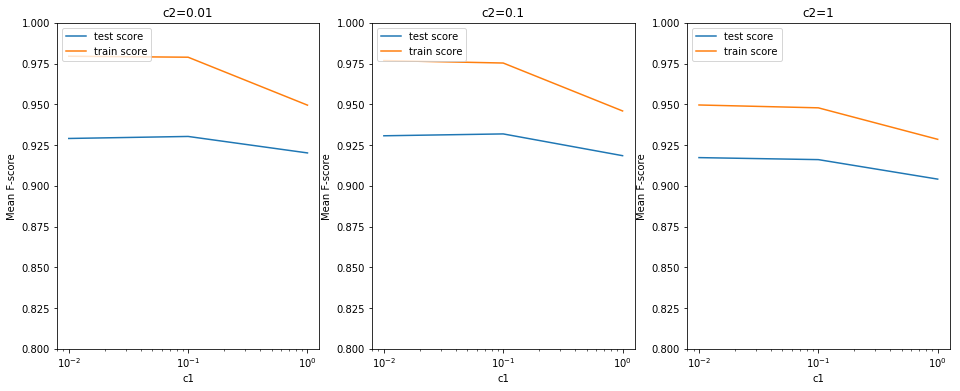

In [120]:
# plotting CV results

plt.figure(figsize=(16,6))

for i, val in enumerate(params_space['c2']):
   
    # subplot 1/3/i
    plt.subplot(1, 3, i+1)
    c2_subset = cv_results[cv_results['param_c2']==val]

    plt.plot(c2_subset["param_c1"], c2_subset["mean_test_score"])
    plt.plot(c2_subset["param_c1"], c2_subset["mean_train_score"])
    plt.xlabel('c1')
    plt.ylabel('Mean F-score')
    plt.title("c2={0}".format(val))
    plt.ylim([0.80, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

The plot above shows that at very low values of c_1, the model overfits, as shown by the difference in training and test performance. Also, the test score seems to be slightly higher for c_2 = 0.1.

Let's thus choose c_1 = 0.1 and c_2 = 0.1. 

In [122]:
# building a model with optimal hyperparams
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.1, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

### Make Predictions 

Let's now use the trained model to make predictions.

In [126]:
# remove 'O' from the labels
labels =list(crf.classes_)
labels.remove('O')

# make predictions on validation data
y_pred = crf.predict(X_valid)
metrics.flat_f1_score(y_valid, y_pred,
                      average='weighted', labels=labels)

c:\users\kshitij jain\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\kshitij jain\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.9358802464006175

In [127]:
# class-wise scores
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_valid, y_pred, labels=sorted_labels, digits=3
))

c:\users\kshitij jain\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\kshitij jain\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


                              precision    recall  f1-score   support

             B-aircraft_code      1.000     1.000     1.000         3
              B-airline_code      1.000     0.963     0.981        27
              B-airline_name      1.000     0.993     0.996       139
              I-airline_name      1.000     0.975     0.987        80
              B-airport_code      0.800     0.800     0.800         5
              B-airport_name      0.500     0.429     0.462         7
              I-airport_name      0.667     0.444     0.533         9
 B-arrive_date.date_relative      0.000     0.000     0.000         1
      B-arrive_date.day_name      0.250     0.071     0.111        14
    B-arrive_date.day_number      0.600     0.353     0.444        17
    I-arrive_date.day_number      0.000     0.000     0.000         2
    B-arrive_date.month_name      0.600     0.353     0.444        17
      B-arrive_time.end_time      1.000     0.571     0.727         7
      I-arrive_time

In [ ]:
# # create a tagger object and open the trained file
# tagger = pycrfsuite.Tagger()
# tagger.open('atis.crfsuite')

In [141]:
# tagging a sample sentence
i = 0
sample_sent = valid_labels[i]
print(' '.join(sent2tokens(sample_sent)), end='\n')

what aircraft is used on delta flight DIGITDIGITDIGITDIGIT from kansas city to salt lake city


In [142]:
# compare the predicted and actual labels for a query
print("Predicted:", ' '.join(y_pred[0]))
print('\n')
print("Correct:  ", ' '.join(sent2labels(sample_sent)))

Predicted: O O O O O B-airline_name O B-flight_number O B-fromloc.city_name I-fromloc.city_name O B-toloc.city_name I-toloc.city_name I-toloc.city_name


Correct:   O O O O O B-airline_name O B-flight_number O B-fromloc.city_name I-fromloc.city_name O B-toloc.city_name I-toloc.city_name I-toloc.city_name


In [143]:
# function to create (word, pos_tag, predicted_iob_label) tuples for a given dataset
def append_predicted_tags(pos_tagged_data, labels):
    iob_labels = []
    for sent in list(zip(pos_tagged_data, labels)):
        pos = sent[0]
        labels = sent[1]
        l = list(zip(pos, labels))
        tuple_3 = [(i[0][0], i[0][1], i[1]) for i in l]
        iob_labels.append(tuple_3)
    return iob_labels

In [144]:
# predictions of IOB tags on a sample validation query 
valid_tags = append_predicted_tags(valid_pos, y_pred)
valid_tags[0]

[('what', 'WP', 'O'),
 ('aircraft', 'NN', 'O'),
 ('is', 'VBZ', 'O'),
 ('used', 'VBN', 'O'),
 ('on', 'IN', 'O'),
 ('delta', 'JJ', 'B-airline_name'),
 ('flight', 'NN', 'O'),
 ('DIGITDIGITDIGITDIGIT', 'NNP', 'B-flight_number'),
 ('from', 'IN', 'O'),
 ('kansas', 'NNP', 'B-fromloc.city_name'),
 ('city', 'NN', 'I-fromloc.city_name'),
 ('to', 'TO', 'O'),
 ('salt', 'VB', 'B-toloc.city_name'),
 ('lake', 'JJ', 'I-toloc.city_name'),
 ('city', 'NN', 'I-toloc.city_name')]

In [145]:
# create a tree using the assigned iob labels
valid_trees = [conlltags2tree(sent) for sent in valid_tags]
print(valid_trees[0])

(S
  what/WP
  aircraft/NN
  is/VBZ
  used/VBN
  on/IN
  (airline_name delta/JJ)
  flight/NN
  (flight_number DIGITDIGITDIGITDIGIT/NNP)
  from/IN
  (fromloc.city_name kansas/NNP city/NN)
  to/TO
  (toloc.city_name salt/VB lake/JJ city/NN))


### Traversing a Chunked Tree

Now that we have labelled (chunked) the validation and test datasets, let's see how we can traverse the trees.

In [149]:
i = random.randrange(len(valid_trees))
i=771
chunked_tree = valid_trees[i]

print(' '.join([id_to_words[val] for val in val_x[i]]), '\n')

# traverse the tree and print labels of subtrees 
for n in chunked_tree:
    if isinstance(n, nltk.tree.Tree):
        print(n.label(), n.leaves())

show me all flights from baltimore or denver or pittsburgh that fly to philadelphia 

fromloc.city_name [('baltimore', 'NN')]
or [('or', 'CC')]
fromloc.city_name [('denver', 'NN')]
or [('or', 'CC')]
fromloc.city_name [('pittsburgh', 'NN')]
toloc.city_name [('philadelphia', 'VB')]


In [150]:
# correctly parsed complex queries - i= 771, 25, 473, 23, 498, 893, 882, 694
# ambiguous queries: not many so far
i

771

In [151]:
# list all labels of train and validation trees
tree_labels = []
for tree in train_trees:
    for n in tree:
        if isinstance(n, nltk.tree.Tree):
            tree_labels.append(n.label())

In [152]:
# training set has 78 unique labels
label_set = set(tree_labels)
len(label_set)

78

In [153]:
# print first few labels
list(label_set)[:10]

['depart_time.time_relative',
 'fromloc.state_name',
 'return_time.period_of_day',
 'fare_amount',
 'depart_date.month_name',
 'return_date.date_relative',
 'fromloc.city_name',
 'depart_time.time',
 'class_type',
 'meal_description']

### Understanding the CRF Classifier

Let's now try to understand what the classifier has learnt. 

In [157]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
B-fromloc.airport_name -> I-fromloc.airport_name 6.139828
B-airport_name -> I-airport_name 6.040046
B-depart_date.month_name -> B-depart_date.day_number 5.786839
B-airline_name -> I-airline_name 5.694494
B-arrive_date.month_name -> B-arrive_date.day_number 5.679481
B-city_name -> I-city_name 5.639162
B-toloc.airport_name -> I-toloc.airport_name 5.543314
B-fromloc.city_name -> I-fromloc.city_name 5.271730
B-flight_time -> I-flight_time 5.235649
B-stoploc.city_name -> I-stoploc.city_name 5.072771
B-toloc.city_name -> I-toloc.city_name 4.924069
I-fromloc.airport_name -> I-fromloc.airport_name 4.912550
I-depart_date.today_relative -> I-depart_date.today_relative 4.905395
B-depart_time.time_relative -> B-depart_time.time 4.724515
B-depart_date.day_number -> I-depart_date.day_number 4.704134
B-depart_time.time -> I-depart_time.time 4.514564
B-depart_time.end_time -> I-depart_time.end_time 4.491012
I-flight_time -> I-flight_time 4.480120
B-arrive_time.end_time -> I-arr

In [158]:
# important features
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
5.297233 B-fromloc.city_name prevword:from
5.104957 B-arrive_time.time_relative prevword:arriving
5.059366 B-arrive_time.time_relative prevword:arrive
4.949039 B-toloc.state_name word_is_state
4.017096 B-depart_time.start_time prevword:between
3.841796 B-stoploc.city_name prevword:through
3.826135 B-fromloc.city_name prevword:leaving
3.819081 O        pos:DT
3.725986 I-depart_date.day_number prevword:twenty
3.703128 B-toloc.city_name prevword:into
3.588173 B-arrive_time.start_time prevword:between
3.566806 B-fromloc.airport_name prevword:from
3.506935 B-fromloc.city_name prevword:between
3.481669 B-fromloc.city_name prevword:leave
3.457800 B-stoploc.city_name prevword:via
3.419583 B-toloc.city_name prevword:for
3.369874 B-flight_number prevword:flight
3.310759 B-toloc.city_name prevword:downtown
3.298952 B-city_name prevword:serve
3.286938 B-toloc.city_name prevword:arriving
3.281605 B-flight_mod nextword:flight
3.273857 O        suff_1:e
3.221108 B-fromloc.city_name prev

### Predictions on Test Data

In [160]:
# TBD

### FlightStats API Experiments

WIP

In [ ]:
# flightstats API experiments
app_id = '9bed5b33'
app_key = 'd7a448569ce9d0821da4fcc9f371e8cc'

base_url = 'https://api.flightstats.com/flex/schedules/rest/v1/json/from/'

# {departureAirportCode}/to/{arrivalAirportCode}/departing/{year}/{month}/{day}
# departing from ABQ to DFW on 20 Dec 2018
extended_url = 'ABQ/to/DFW/departing/2018/12/20'

# credentials
creds = '?appId={0}&appKey={1}'.format(app_id, app_key)

# complete url
url = base_url + extended_url + creds
print(url)

In [ ]:
import requests, json
data = requests.get(url).json()

In [ ]:
# sample flight details
data['scheduledFlights'][0]

In [ ]:
# https://developer.flightstats.com/api-docs/scheduledFlights/v1
# https://developer.flightstats.com/api-docs/
# https://developer.flightstats.com/api-docs/how_to